In [1]:
###########################################################################################
# Waleed. M Gondal, 2017                                                                  #
# Use of Conditional Random Fields to improve Class Activation Maps results in TensorFlow #
# Weights from Caffe converted using https://github.com/ethereon/caffe-tensorflow         #
###########################################################################################

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from scipy.misc import imread, imresize
from imagenet_classes import class_names
from utils import normalize, draw_bbox, threshold_hmap, draw_bbox_binary
from cam_model import CAM
import skimage.io as io
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, softmax_to_unary, unary_from_softmax

In [2]:
# Assign weight file.
weight_path = 'vgg16CAM.npy'
n_labels = 1000
cam = CAM(n_labels, weight_path)

# Define Placeholders for images and labels
images_tf = tf.placeholder( tf.float32, [None, 224, 224, 3], name="images")
labels_tf = tf.placeholder( tf.int32, [None], name='labels')

In [3]:
# Configure the model
fmaps, output = cam.network(images_tf)

# Read Test image
Read and resize the image

(-0.5, 223.5, 223.5, -0.5)

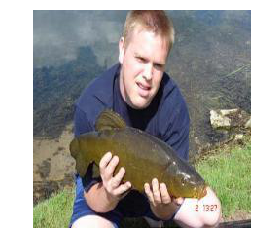

In [4]:
img = imread('1.JPEG', mode='RGB')
img = imresize(img, (224, 224))
plt.imshow (img)
plt.axis('off')

# CAM Inference
Retrieve the last convolution layer's feature maps and the output scores

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
fmaps_val, output_val= sess.run([fmaps, output], feed_dict={ images_tf: np.expand_dims(img, axis = 0)})  

# Sort output scores 
sorted_output = (output_val.argsort(axis=1)[:,-3:])[0:5]

# Assign Max Predictions
label_1 = sorted_output[:,-1] 
label_2 = sorted_output[:,-2] 

# Class Activation Maps
Pass the retrieved feature maps and the indexes of output nodes associated with 2 highest predictions 

(-0.5, 223.5, 223.5, -0.5)

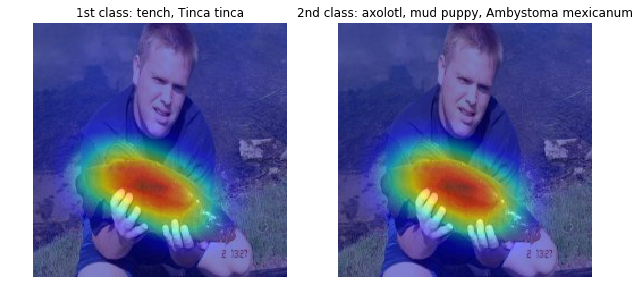

In [6]:
sorted_output = np.squeeze(sorted_output)

# Define classmap object
classmap = cam.get_cam(labels_tf, fmaps)

# Retrieve Class Maps 
classmap_1 = sess.run(classmap, feed_dict={ labels_tf: label_1, fmaps: fmaps_val})
classmap_2 = sess.run(classmap, feed_dict={ labels_tf: label_2, fmaps: fmaps_val})
cmap_1 = np.squeeze(classmap_1, axis=(0,))
cmap_2 = np.squeeze(classmap_2, axis=(0,))

# Plot Images and their respective Heatmaps
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(img)
axs[0].imshow(normalize(cmap_1), cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
axs[0].set_title('1st class: %s' %class_names[sorted_output[-1]])
axs[0].axis('off')

axs[1].imshow(img)
axs[1].imshow(normalize(cmap_2), cmap=plt.cm.jet, alpha=0.5, interpolation='nearest')
axs[1].set_title('2nd class: %s' %class_names[sorted_output[-2]])
axs[1].axis('off')

# Normalize and Threshold the mask
Normalize the mask between 0 and 1 as it will give each pixel a probabilistic value according to its intensity

(224, 224)


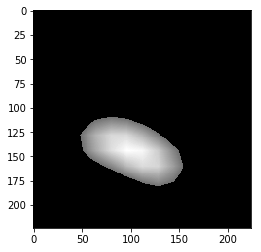

In [7]:
norm_hmap =(normalize(cmap_1))/255.
norm_hmap = threshold_hmap(norm_hmap)
plt.imshow(norm_hmap, cmap='gray')

# Prior Probability Masks
It's is essential for CRFs to have a prior probability mask which defines the probabilities attached to the unary mask

(-0.5, 223.5, 223.5, -0.5)

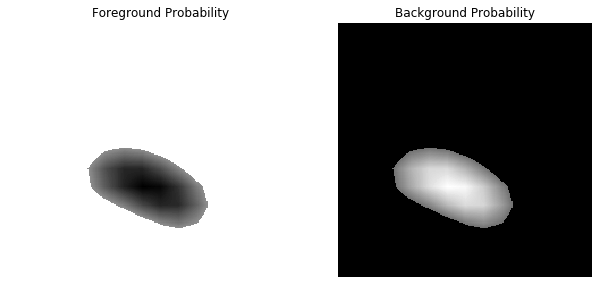

In [8]:
# The first dimension needs to be equal to the number of classes (in prob map), lets have one class for forground and 
# one for background. Replicate the prob maps and invert it to create the probability of background class
prob_maps = np.tile(norm_hmap[np.newaxis,:,:], (2,1,1))
prob_maps[1,:,:] = 1 - prob_maps[0,:,:]
fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(prob_maps[1,:,:], cmap='gray')
axs[0].set_title('Foreground Probability')
axs[0].axis('off')
axs[1].imshow(prob_maps[0,:,:], cmap='gray')
axs[1].set_title('Background Probability')
axs[1].axis('off')

(-0.5, 223.5, 223.5, -0.5)

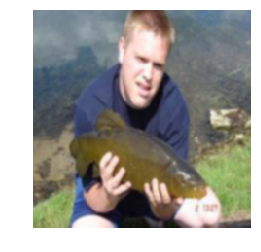

In [9]:
# Smoothen the image using gaussian blur
img = cv2.GaussianBlur(img, (5,5),0)
plt.imshow(img)
plt.axis('off')

# Potential Function
A pairwise potential function is used (in 2D graph, first assumption markov model). Each pixel (node in a graph) is considered to be connected to only four neighbouring pixels with pairwise links.

In [10]:
U = unary_from_softmax(prob_maps)
W, H, n_labels = 224, 224, 2
d = dcrf.DenseCRF(W, H, n_labels)
d.setUnaryEnergy(U)
pairwise_energy = create_pairwise_bilateral(sdims=(10, 10), schan=(20,20,20),img=img, chdim=2)

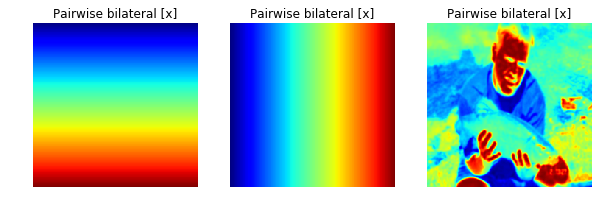

In [15]:
img_en = pairwise_energy.reshape((-1, H, W))
fig, axs = plt.subplots(1,3, figsize=(10,10))

axs[0].imshow(img_en[0], cmap='jet')
axs[0].axis('off')
axs[0].set_title('Pairwise bilateral [x]')
axs[1].imshow(img_en[1], cmap='jet')
axs[1].axis('off')
axs[1].set_title('Pairwise bilateral [x]')
axs[2].imshow(img_en[2], cmap='jet')
axs[2].axis('off')
axs[2].set_title('Pairwise bilateral [x]')

# Minimization of CRFs Energy Function
CRF Energy function (also Gibbs Energy) is composed by the features we want to have from the reference RGB input image. In our can we considered pixel intensity values to be the features and iterated for 50 time to approximate the posterior while minimizing the energy function

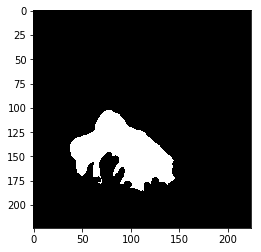

In [12]:
d = dcrf.DenseCRF(W, H, n_labels)
d.setUnaryEnergy(U)
d.addPairwiseEnergy(pairwise_energy, compat=10)
Q, tmp1, tmp2 = d.startInference()
for _ in range(50):
    d.stepInference(Q, tmp1, tmp2)
kl1 = d.klDivergence(Q) / (H*W)
map_soln1 = np.argmax(Q, axis=0).reshape((H,W))

map_soln = 1-map_soln1

plt.imshow(map_soln, cmap='gray')

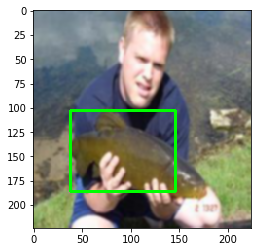

In [13]:
# Draw Bounding Box on the image
binary_mask = np.uint8(map_soln)
image_with_bbox = draw_bbox_binary(img, binary_mask)
plt.imshow(image_with_bbox)